# Desafío

In [1]:
# 1. Selecciona los títulos con `budget` mayor a 10 millones y `popularity` superior a 10.
#    ¿Cuántos títulos cumplen estas condiciones y cuál es su `rating` medio?

# 2. Comprueba si hay títulos duplicados por combinación de `title` y `release_year`.
#    Elimina los duplicados y calcula cuántos eran y qué porcentaje del total representan.

# 3. Agrupa los títulos por `country` y calcula: número de títulos, 
#    `budget` medio, `revenue` medio y `rating` medio en cada país.

# 4. Representa gráficamente la evolución del número de títulos por año (`release_year`)
#    y observa si ha habido un aumento o caída en los últimos años.

# 5. Crea una tabla cruzada con el número de títulos por `country` y década.
#    Representa los 10 países con más títulos usando un gráfico de calor.

# 6. Crea columnas que indiquen si la descripción contiene palabras clave como 
#    "war", "love", "life", "death", etc. 
#    Calcula el porcentaje de títulos que contienen cada una de ellas y compáralo por país.

# 7. Prepara un subconjunto para regresión eliminando nulos en `budget`, `revenue`, `popularity`, y `rating`.
#    Normaliza las variables numéricas y entrena una regresión lineal para predecir el `rating`.

# 8. Crea una variable binaria que indique si el `rating` es alto (por ejemplo, mayor de 7).
#    Entrena un modelo de clasificación (KNN o regresión logística) y evalúalo con precisión y matriz de confusión.

# 9. Extrae la primera palabra de cada título (`title`) y cuenta cuántas veces aparece cada una.
#    Muestra las 10 más frecuentes.

# 10 Agrupa los títulos en clústeres utilizando KMeans sobre las variables numéricas:
# `budget`, `revenue`, `popularity` y `rating`. 
# Muestra cuántos títulos hay en cada clúster y las medias de cada variable por grupo.



In [2]:
# 1 ------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

df = pd.read_csv("titles.csv")

df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")
df["popularity"] = pd.to_numeric(df["popularity"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

filtro = (df["budget"] > 1e7) & (df["popularity"] > 10)
df_filtro = df[filtro]
print("Número de títulos:", len(df_filtro))
print("Rating medio:", round(df_filtro["rating"].mean(), 2))

Número de títulos: 2211
Rating medio: 6.54


In [3]:
# 2 ------------------------------------------------------------
duplicados = df.duplicated(subset=["title", "release_year"])
total_duplicados = duplicados.sum()
porcentaje = round(100 * total_duplicados / len(df), 2)
df = df[~duplicados]
print("Títulos duplicados eliminados:", total_duplicados)
print("Porcentaje del total:", porcentaje, "%")

Títulos duplicados eliminados: 37
Porcentaje del total: 0.23 %


In [15]:
# 3 ------------------------------------------------------------
df["country_clean"] = df["country"].astype(str).str.split(",").str[0].str.strip()

resumen_pais = df.groupby("country_clean")[["budget", "revenue", "rating"]].mean().round(2)
resumen_pais["count"] = df["country_clean"].value_counts()
resumen_pais = resumen_pais.dropna()
resumen_pais

,budget,revenue,rating,count
country_clean,,,,
Afghanistan,0.00,74335.50,6.80,2
Albania,8000000.00,0.00,5.51,2
Algeria,7500000.00,867621.75,6.80,4
Angola,2600000.00,0.00,5.70,1
Argentina,1261156.36,2442138.22,6.31,111
...,...,...,...,...
United States of America,14867830.67,42519091.24,5.98,5689
Uruguay,1500.00,0.00,6.32,4
Venezuela,37500.00,577383.75,7.12,8


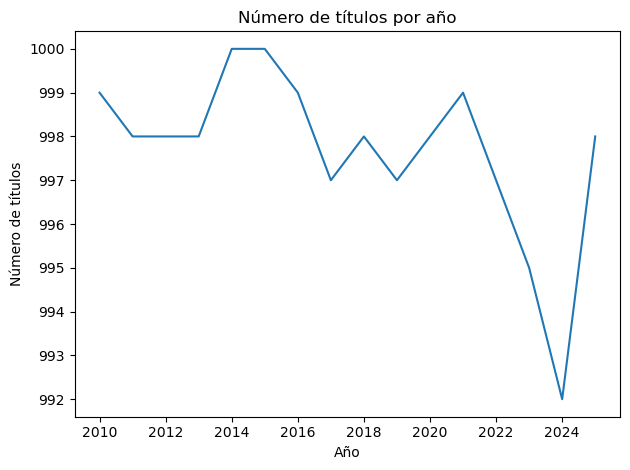

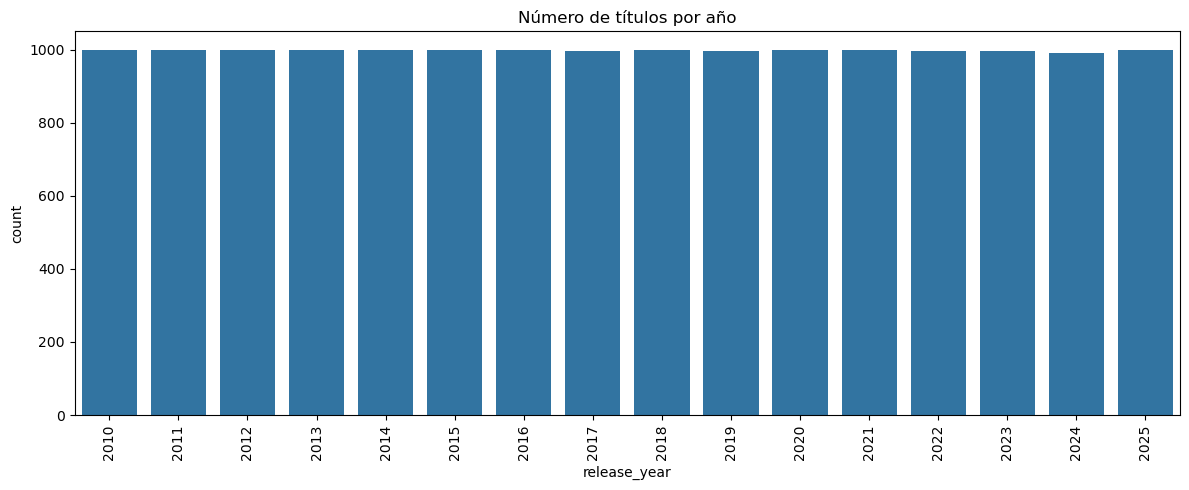

In [16]:
# 4 ------------------------------------------------------------
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")
estrenos_por_anio = df["release_year"].dropna().value_counts().sort_index()

estrenos_por_anio.plot(kind="line", title="Número de títulos por año")
plt.xlabel("Año")
plt.ylabel("Número de títulos")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(data=df, x="release_year", order=sorted(df["release_year"].dropna().unique()))
plt.xticks(rotation=90)
plt.title("Número de títulos por año")
plt.tight_layout()
plt.show()

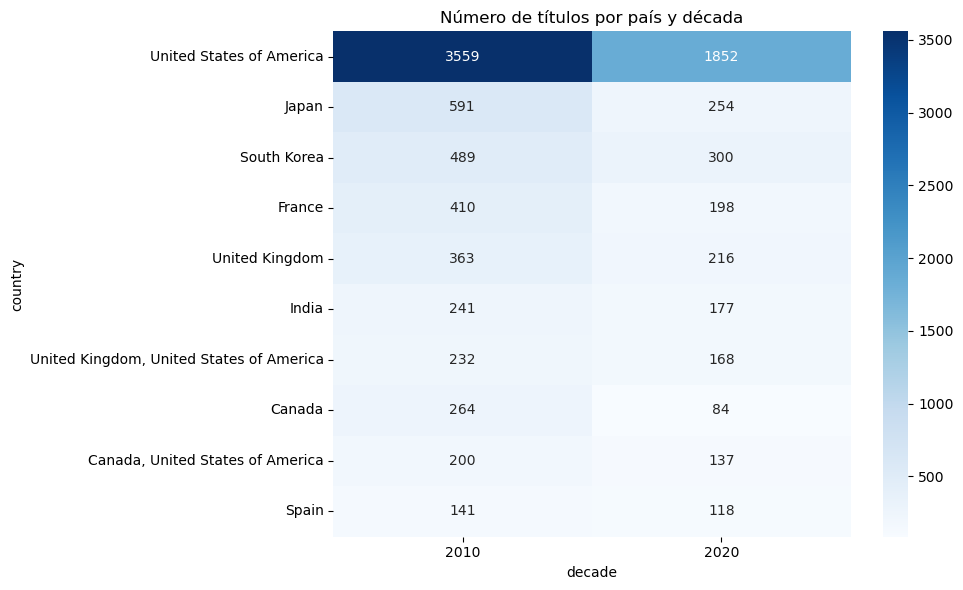

In [17]:
# 5 ------------------------------------------------------------
df["decade"] = (df["release_year"] // 10) * 10
tabla_cruzada = pd.crosstab(df["country"], df["decade"])
top_paises = df["country"].value_counts().head(10).index
tabla_top = tabla_cruzada.loc[top_paises]

plt.figure(figsize=(10,6))
sns.heatmap(tabla_top, annot=True, fmt="d", cmap="Blues")
plt.title("Número de títulos por país y década")
plt.tight_layout()
plt.show()

In [18]:
# 6 ------------------------------------------------------------
df["description"] = df["description"].fillna("").str.lower()
palabras_clave = ["war", "love", "life", "death"]

for palabra in palabras_clave:
    df[palabra + "_flag"] = df["description"].str.contains(r"\b" + palabra + r"\b")

porcentajes = {p: round(100 * df[p + "_flag"].mean(), 2) for p in palabras_clave}
print("Porcentaje de títulos que contienen cada palabra clave:", porcentajes)

if "type" in df.columns:
    comparacion = df.groupby("type")[[p + "_flag" for p in palabras_clave]].mean().round(2)
    print("Comparación entre tipos:")
    print(comparacion)

Porcentaje de títulos que contienen cada palabra clave: {'war': np.float64(3.81), 'love': np.float64(8.25), 'life': np.float64(15.26), 'death': np.float64(3.62)}
Comparación entre tipos:
       war_flag  love_flag  life_flag  death_flag
type                                             
Movie      0.04       0.08       0.15        0.04


In [19]:
# 7 ------------------------------------------------------------
variables = ["budget", "revenue", "popularity", "rating"]
df_reg = df[df["type"] == "Movie"][variables].dropna()
X = df_reg[["budget", "revenue", "popularity"]]
y = df_reg["rating"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
modelo = LinearRegression()
modelo.fit(X_scaled, y)
score_r2 = round(modelo.score(X_scaled, y), 3)
print("R² del modelo de regresión lineal:", score_r2)

R² del modelo de regresión lineal: 0.016


In [20]:
# 8 ------------------------------------------------------------
df_clas = df[df["type"] == "Movie"][["budget", "revenue", "popularity", "rating"]].dropna()
df_clas["target"] = (df_clas["rating"] > 7).astype(int)
X = df_clas[["budget", "revenue", "popularity"]]
y = df_clas["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
modelo = LogisticRegression()
modelo.fit(X_train_scaled, y_train)
y_pred = modelo.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
matriz = confusion_matrix(y_test, y_pred)
print("Precisión del modelo:", round(acc, 3))
print("Matriz de confusión:\n", matriz)

Precisión del modelo: 0.786
Matriz de confusión:
 [[3112   19]
 [ 836   24]]


In [21]:
# 9 ------------------------------------------------------------
df["first_word"] = df["title"].astype(str).str.split().str[0]
top_10_palabras = df["first_word"].value_counts().head(10)
print("Top 10 primeras palabras en títulos:\n", top_10_palabras)

Top 10 primeras palabras en títulos:
 first_word
The      2644
A         322
My        155
I          85
Love       84
In         65
Black      58
All        57
One        56
No         46
Name: count, dtype: int64


In [24]:
# 10 ------------------------------------------------------------
from sklearn.cluster import KMeans

df_cluster = df[["budget", "revenue", "popularity", "rating"]].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

modelo_kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster["cluster"] = modelo_kmeans.fit_predict(X_scaled)

print("Número de títulos por clúster:")
print(df_cluster["cluster"].value_counts().sort_index())

print("\nMedias por clúster:")
print(df_cluster.groupby("cluster")[["budget", "revenue", "popularity", "rating"]].mean().round(2))


Número de títulos por clúster:
cluster
0    14492
1      427
2     1034
3       10
Name: count, dtype: int64

Medias por clúster:
               budget       revenue  popularity  rating
cluster                                                
0        5.072805e+06  1.099770e+07       17.73    6.33
1        1.508201e+08  5.365964e+08       82.91    6.79
2        1.406615e+06  1.191860e+05       11.34    0.31
3        8.280000e+07  2.682937e+08     2155.95    7.05


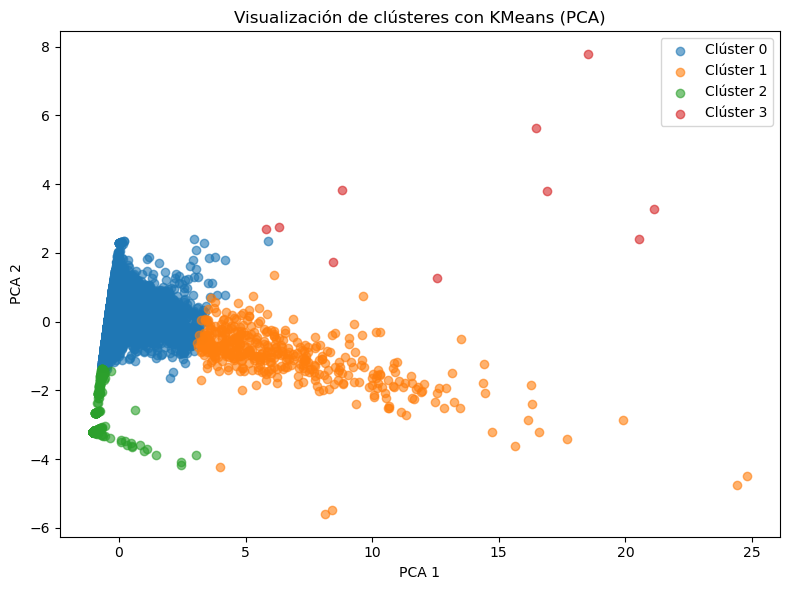

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster["PCA1"] = X_pca[:, 0]
df_cluster["PCA2"] = X_pca[:, 1]

# Scatter plot
plt.figure(figsize=(8,6))
for cluster_id in sorted(df_cluster["cluster"].unique()):
    subset = df_cluster[df_cluster["cluster"] == cluster_id]
    plt.scatter(subset["PCA1"], subset["PCA2"], label=f"Clúster {cluster_id}", alpha=0.6)

plt.title("Visualización de clústeres con KMeans (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()